# Getting Started with Jupyter Notebook for MRI Diagnosis

This notebook will guide you through the basics of using Jupyter Notebook and set up a workflow for MRI image diagnosis using PyTorch.

In [17]:
%pip install notebook

# Check if Jupyter is installed and display its version
try:
    import notebook
    print(f"Jupyter Notebook version: {notebook.__version__}")
except ImportError:
    print("Jupyter Notebook is not installed.")

Note: you may need to restart the kernel to use updated packages.
Jupyter Notebook version: 7.4.5
Note: you may need to restart the kernel to use updated packages.
Jupyter Notebook version: 7.4.5


## Add and Run Code Cells

To add a new code cell, click the '+' button or use the menu. Enter Python code and press Shift+Enter to run the cell and see the output below it.

In [18]:
# Import required libraries for MRI diagnosis
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models 
from torch.utils.data import DataLoader, Dataset

## Define data transforms and load MRI datasets

In [19]:
# Set the path to the data directory
data_dir = '../data'

# Define data transformations for preprocessing MRI images
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(), # Convert PIL images to PyTorch tensors
    # Normalize pixel values to [-1, 1] range for better model performance
    # Formula: (x - mean) / std, where mean=0.5 and std=0.5
    transforms.Normalize((0.5,), (0.5,))
])

# Load training dataset using ImageFolder, which expects data organised in folders by class (suits my data well)
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'Training'), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'Testing'), transform=transform) # used os equivalent to ../data/Testing

# Create data loaders for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print dataset sizes for verification
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 5712
Number of test samples: 1311


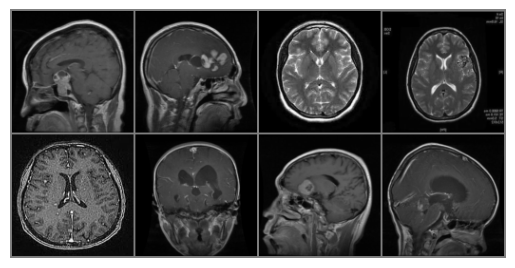

Labels: [3 0 2 2 2 0 1 0]


In [20]:
import torchvision  # Import torchvision for image utilities

# Visualise a batch of MRI images
def imshow(img):
    img = img * 0.5 + 0.5  # Undo normalisation to bring pixel values back to [0, 1] for display
    npimg = img.numpy()  # Convert the tensor to a NumPy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray') # Change (channels, height, width) to (height, width, channels) for matplotlib
    plt.axis('off')
    plt.show()

# Get a batch of training data (images and labels)
images, labels = next(iter(train_loader))

# Show a grid of the first 8 images in the batch
imshow(torchvision.utils.make_grid(images[:8], nrow=4))
print('Labels:', labels[:8].numpy())  # label = data class

In [21]:
# Define a simple CNN model for MRI classification

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__() # super() gives you access to methods from a parent (or superclass) class
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1), # convolution uses a 3x3 filter, padding adds border of 1 pixel around input
            nn.ReLU(),
            nn.MaxPool2d(2), # downsamples the feature map by taking the maximum value in each 2x2 window
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(), # turns into a 1D tensor
            nn.Linear(32 * 32 * 32, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes) # final layer that outputs a value for each class (e.g., tumor types), used for classification
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

num_classes = len(train_dataset.classes)
model = SimpleCNN(num_classes)
print(model)

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=4, bias=True)
  )
)


In [22]:
# Set up loss function, optimizer, and device

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [23]:
# Training loop

epochs = 10  # Increase for better results
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/10, Loss: 0.7923
Epoch 2/10, Loss: 0.3606
Epoch 2/10, Loss: 0.3606
Epoch 3/10, Loss: 0.2322
Epoch 3/10, Loss: 0.2322
Epoch 4/10, Loss: 0.1486
Epoch 4/10, Loss: 0.1486
Epoch 5/10, Loss: 0.0850
Epoch 5/10, Loss: 0.0850
Epoch 6/10, Loss: 0.0590
Epoch 6/10, Loss: 0.0590
Epoch 7/10, Loss: 0.0441
Epoch 7/10, Loss: 0.0441
Epoch 8/10, Loss: 0.0380
Epoch 8/10, Loss: 0.0380
Epoch 9/10, Loss: 0.0173
Epoch 9/10, Loss: 0.0173
Epoch 10/10, Loss: 0.0182
Epoch 10/10, Loss: 0.0182


In [24]:
# Evaluate the model on the test set

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 96.11%


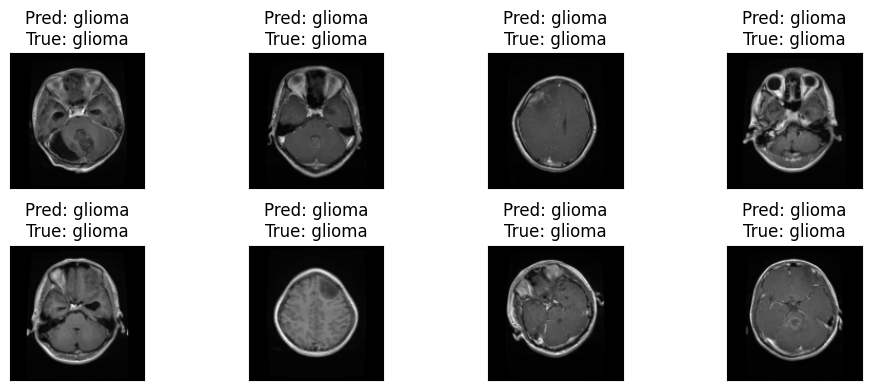

In [9]:
# Visualize predictions on a few test images

dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)

fig = plt.figure(figsize=(10, 4))
for idx in range(8):
    ax = fig.add_subplot(2, 4, idx+1, xticks=[], yticks=[])
    img = images[idx].cpu().numpy().squeeze()
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Pred: {train_dataset.classes[preds[idx]]}\nTrue: {train_dataset.classes[labels[idx]]}")
plt.tight_layout()
plt.show()

## Experimenting with accuracy

Increasing epochs to 10 resulted in higher accuracy and lower test loss.